# Tracking speed - Benchmarks

In this experiment, we evaluate the tracking performance of:

* MLflow - https://mlflow.org/
* WandB - https://wandb.ai/
* Neptune - https://neptune.ai/
* Aim - https://aimstack.io/
* Comet - https://www.comet.com/
* MLtraq - https://mltraq.com/

Varying:

* Number of experiments tracked
* Number of runs tracked
* Number of values tracked

Configuration:
* Tracking `float` values, disabling everything else such as git, code, environment and system stats
* Experiments running/tracking offline, logging disabled, storage on local filesystem
* Every experiment starts with an empty directory for storage
* Results averaged on `10` runs


## Imports and utility functions

In [2]:
%load_ext pyinstrument

In [3]:
import logging
import shutil
import threading
import uuid
from contextlib import contextmanager, redirect_stderr, redirect_stdout
from os import devnull, environ, makedirs, remove

import aim
import comet_ml
import matplotlib.pyplot as plt
import mlflow
import neptune
import pandas as pd
import wandb

import mltraq
from mltraq.utils.plot import bar_plot

In [4]:
# Versions

print("mlflow", mlflow.__version__)
print("neptune", neptune.__version__)
print("wandb", wandb.__version__)
print("aim", aim.__version__.__version__)
print("comet", comet_ml.__version__)
print("mltraq", mltraq.__version__)

mlflow 2.10.2
neptune 1.9.1
wandb 0.16.3
aim 3.18.1
comet 3.38.0
mltraq 0.0.118


In [5]:
# Utility functions


@contextmanager
def suppress_stdout_stderr():
    """
    A context manager that redirects stdout and stderr to devnull.
    """
    with open(devnull, "w") as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)


def remove_file(pathname):
    """
    Remove file `pathname` if existing.
    """
    try:
        remove(pathname)
    except OSError:
        pass


def create_dir(pathdir):
    """
    Create `pathdir` recursively. If it already exists, do nothing.
    """
    makedirs(pathdir, exist_ok=True)

## Test procedure for WandB

In [29]:
def test_wandb(n_experiments=1, n_runs=1, n_values=1):
    """
    Test Weights & Biases tracking with a specified number of experiments, runs and values.
    """

    # Required to silence Python output and disable sentry tracking.
    # This must be inside the test function to propagate to child processes.
    environ["WANDB_SILENT"] = "true"
    environ["WANDB_ERROR_REPORTING"] = "false"
    environ["WANDB_DISABLE_GIT"] = "true"
    environ["DISABLE_CODE"] = "true"

    tmp_dir = f"tmp/{uuid.uuid4()}"
    create_dir(f"{tmp_dir}/wandb")
    for _ in range(n_experiments):
        experiment_id = str(uuid.uuid4())
        for _ in range(n_runs):
            run_id = str(uuid.uuid4())
            wandb.init(
                project=experiment_id,
                group=run_id,
                dir=tmp_dir,
                mode="offline",
            )
            for _ in range(n_values):
                wandb.log({"value": 123.45})
    wandb.finish()

In [30]:
%%pyinstrument
test_wandb()


_     ._   __/__   _ _  _  _ _/_   Recorded: 09:34:16  Samples:  61
 /_//_/// /_\ / //_// / //_'/ //     Duration: 1.662     CPU time: 0.096
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-b12f0bf1-828b-4aa4-b878-da173f7225ce.json

1.661 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_1283/1666376201.py:1
`- 1.661 test_wandb  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_1283/581603400.py:1
   |- 1.593 finish  wandb/sdk/wandb_run.py:4108
   |     [28 frames hidden]  wandb, threading, <built-in>, sentry_sdk
   |        1.002 lock.acquire  <built-in>
   |        0.455 lock.acquire  <built-in>
   `- 0.067 init  wandb/sdk/wandb_init.py:940
         [9 frames hidden]  wandb, threading, <built-in>

## Test procedure for MLflow

In [31]:
def test_mlflow(n_experiments=1, n_runs=1, n_values=1):
    """
    Test MLflow tracking with a specified number of experiments, runs and values.
    """

    create_dir("tmp")
    db_fname = f"tmp/{uuid.uuid4()}.db"
    mlflow.set_tracking_uri(f"sqlite:///{db_fname}")
    for _ in range(n_experiments):
        experiment_id = mlflow.create_experiment(str(uuid.uuid4()))
        for _ in range(n_runs):
            with mlflow.start_run(experiment_id=experiment_id):
                for _ in range(0, n_values):
                    mlflow.log_metric(key="value", value=123.45)
            mlflow.end_run()
    remove_file(db_fname)

In [32]:
%%pyinstrument
test_mlflow()


_     ._   __/__   _ _  _  _ _/_   Recorded: 09:34:30  Samples:  161
 /_//_/// /_\ / //_// / //_'/ //     Duration: 1.578     CPU time: 0.694
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-b12f0bf1-828b-4aa4-b878-da173f7225ce.json

1.579 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_1283/2371405818.py:1
`- 1.579 test_mlflow  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_1283/625529744.py:1
   |- 1.410 ActiveRun.__exit__  mlflow/tracking/fluent.py:191
   |     [17 frames hidden]  mlflow, comet_ml, threading, <built-in>
   |        0.782 lock.acquire  <built-in>
   |        0.550 lock.acquire  <built-in>
   |- 0.131 create_experiment  mlflow/tracking/fluent.py:1532
   |     [20 frames hidden]  mlflow, alembic, <string>
   `- 0.038 wrapper  comet_ml/monkey_patching.py:261
         [10 frames hidden]  comet_ml, <built-in>

INFO  [alembic.runtime.migration] Running upgrade a8c4a736bde6 -> 39d1c3be5f05, add_is_nan_constraint_for_metrics_tables_if_necessary


INFO  [alembic.runtime.migration] Running upgrade 39d1c3be5f05 -> c48cb773bb87, reset_default_value_for_is_nan_in_metrics_table_for_mysql


INFO  [alembic.runtime.migration] Running upgrade c48cb773bb87 -> bd07f7e963c5, create index on run_uuid


INFO  [alembic.runtime.migration] Running upgrade bd07f7e963c5 -> 0c779009ac13, add deleted_time field to runs table


INFO  [alembic.runtime.migration] Running upgrade 0c779009ac13 -> cc1f77228345, change param value length to 500


INFO  [alembic.runtime.migration] Running upgrade cc1f77228345 -> 97727af70f4d, Add creation_time and last_update_time to experiments table


INFO  [alembic.runtime.migration] Running upgrade 97727af70f4d -> 3500859a5d39, Add Model Aliases table


INFO  [alembic.runtime.migration] Running upgrade 3500859a5d39 -> 7f2a7d5fae7d, add datasets inputs input_tags tables


INFO  [alembic.runtime.migration] Running upgrade 7f2a7d5fae7d -> 2d6e25af4d3e, increase max param val length from 500 to 8000


INFO  [alembic.runtime.migration] Running upgrade 2d6e25af4d3e -> acf3f17fdcc7, add storage location field to model versions


INFO  [alembic.runtime.migration] Context impl SQLiteImpl.


INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


COMET INFO: No Comet API Key was found, creating an OfflineExperiment. Set up your API Key to get the full Comet experience https://www.comet.com/docs/python-sdk/advanced/#python-configuration


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


COMET INFO: Using '/Users/michele/dev/mltraq/notebooks/.cometml-runs' path as offline directory. Pass 'offline_directory' parameter into constructor or set the 'COMET_OFFLINE_DIRECTORY' environment variable to manually choose where to store offline experiment archives.


COMET INFO: ---------------------------------------------------------------------------------------


COMET INFO: Comet.ml OfflineExperiment Summary


COMET INFO: ---------------------------------------------------------------------------------------


COMET INFO:   Data:


COMET INFO:     display_summary_level : 1


COMET INFO:     url                   : [OfflineExperiment will get URL after upload]


COMET INFO:   Metrics:


COMET INFO:     value : 123.45


COMET INFO:   Others:


COMET INFO:     Created from       : MLFlow auto-logger


COMET INFO:     offline_experiment : True


COMET INFO:   Uploads:


COMET INFO:     environment details      : 1


COMET INFO:     filename                 : 1


COMET INFO:     git metadata             : 1


COMET INFO:     git-patch (uncompressed) : 1 (26.63 KB)


COMET INFO:     installed packages       : 1


COMET INFO:     notebook                 : 1


COMET INFO:     source_code              : 1


COMET INFO: 


COMET WARNING: Experiment Name is generated at upload time for Offline Experiments unless set explicitly with Experiment.set_name


COMET INFO: Still saving offline stats to messages file before program termination (may take up to 120 seconds)


COMET INFO: Starting saving the offline archive


COMET INFO: To upload this offline experiment, run:
    comet upload /Users/michele/dev/mltraq/notebooks/.cometml-runs/5a48e1b0d0d746868b4f6d2fa62ece8a.zip


_     ._   __/__   _ _  _  _ _/_   Recorded: 22:03:39  Samples:  540
 /_//_/// /_\ / //_// / //_'/ //     Duration: 2.037     CPU time: 0.861
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /private/var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/tmp5sejp_m_.json --HistoryManager.hist_file=:memory:

2.036 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_32841/2371405818.py:1
`- 2.036 test_mlflow  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_32841/625529744.py:1
   |- 1.332 ActiveRun.__exit__  mlflow/tracking/fluent.py:191
   |     [13 frames hidden]  mlflow, comet_ml, threading, <built-in>
   |        1.085 lock.acquire  <built-in>
   |- 0.582 create_experiment  mlflow/tracking/fluent.py:1532
   |     [78 frames hidden]  mlflow, alembic, <string>, sqlalchemy...
   `- 0.122 wrapper  comet_ml/monkey_patching.py:261
         [16 frames hidden]  comet_ml, <built-in>, mlflow

## Test procedure for Neptune

In [33]:
def test_neptune(n_experiments=1, n_runs=1, n_values=1):
    """
    Test Neptune tracking with a specified number of experiments, runs and values.
    """

    for _ in range(n_experiments):
        # No "experiment" concept in Neptune, and we cannot create "projects" offline on the free plan.
        # Also, not easy to set a custom directory, it will log things in .neptune/
        for _ in range(n_runs):
            run = neptune.init_run(
                project=f"workspace/{str(uuid.uuid4())}",
                mode="offline",
                git_ref=False,
            )
            for _ in range(0, n_values):
                run["value"].append(123.45)
            run.wait()
            run.stop()

In [34]:
%%pyinstrument
test_neptune()

_     ._   __/__   _ _  _  _ _/_   Recorded: 09:34:49  Samples:  11
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.013     CPU time: 0.014
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-b12f0bf1-828b-4aa4-b878-da173f7225ce.json

0.011 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_1283/3214493869.py:1
`- 0.011 test_neptune  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_1283/3319462458.py:1
   |- 0.009 Run.__init__  neptune/metadata_containers/run.py:307
   |     [41 frames hidden]  neptune, pathlib, <built-in>, <frozen...
   |- 0.001 Run.stop  neptune/metadata_containers/metadata_container.py:410
   |     [2 frames hidden]  neptune
   `- 0.001 Handler.inner_fun  neptune/handler.py:85
         [5 frames hidden]  neptune

## Test procedure for Aim

In [35]:
def test_aim(n_experiments=1, n_runs=1, n_values=1):
    """
    Test Aim tracking with a specified number of experiments, runs and values.
    """

    create_dir("tmp/aim/")
    repo = f"tmp/aim/{uuid.uuid4()}"
    for _ in range(n_experiments):
        for _ in range(n_runs):
            run_id = str(uuid.uuid4())
            # Doc: https://aimstack.readthedocs.io/en/latest/refs/sdk.html#aim.sdk.run.Run
            # Experiments in Aim match to what we call runs in this notebook.
            run = aim.Run(
                repo=repo,
                experiment=run_id,
                system_tracking_interval=None,
                capture_terminal_logs=False,
            )
            for _ in range(0, n_values):
                run.track({"value": 123.45})

In [36]:
%%pyinstrument
test_aim()

_     ._   __/__   _ _  _  _ _/_   Recorded: 09:35:01  Samples:  45
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.824     CPU time: 0.097
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-b12f0bf1-828b-4aa4-b878-da173f7225ce.json

0.823 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_1283/3340399674.py:1
|- 0.740 test_aim  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_1283/1876961650.py:1
|  `- 0.739 wrapper  aim/ext/exception_resistant.py:65
|        [46 frames hidden]  aim, subprocess, <built-in>, sqlalchemy
|           0.392 waitpid  <built-in>
`- 0.083 finalize.__call__  weakref.py:585
      [2 frames hidden]  weakref

## Test procedure for Comet

In [37]:
def test_comet(n_experiments=1, n_runs=1, n_values=1):
    """
    Test Comet tracking with a specified number of experiments, runs and values.
    """

    tmp_dir = f"tmp/comet/{uuid.uuid4()}"
    create_dir(tmp_dir)
    for _ in range(n_experiments):
        experiment_id = str(uuid.uuid4())
        for _ in range(n_runs):
            run_id = str(uuid.uuid4().hex)  # Only alphanum IDs for Comet experiments, which match our semantics of runs
            run = comet_ml.OfflineExperiment(
                project_name=experiment_id,
                log_code=False,
                log_graph=False,
                log_env_gpu=False,
                log_env_cpu=False,
                log_env_network=False,
                log_env_disk=False,
                log_env_host=False,
                log_git_metadata=False,
                offline_directory=tmp_dir,
                experiment_key=run_id,
                display_summary_level=0,
            )
            for _ in range(0, n_values):
                run.log_metrics({"value": 123.45})
            run.end()

In [38]:
%%pyinstrument
test_comet()

_     ._   __/__   _ _  _  _ _/_   Recorded: 09:35:13  Samples:  21
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.087     CPU time: 0.036
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-b12f0bf1-828b-4aa4-b878-da173f7225ce.json

0.086 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_1283/3382937944.py:1
`- 0.086 test_comet  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_1283/3417524710.py:1
   |- 0.069 OfflineExperiment.end  comet_ml/experiment.py:686
   |     [23 frames hidden]  comet_ml, <built-in>, threading, zipf...
   |        0.055 sleep  <built-in>
   |- 0.016 OfflineExperiment.__init__  comet_ml/offline.py:231
   |     [58 frames hidden]  comet_ml, logging, ipykernel, threadi...
   `- 0.001 create_dir  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_1283/1120774479.py:24
      `- 0.001 makedirs  <frozen os>:200
            [4 frames hidden]  <frozen os>, <frozen genericpath>, <b...

## Test procedure for MLtraq

In [39]:
def test_mltraq(n_experiments=1, n_runs=1, n_values=1):
    """
    Test MLtraq tracking with a specified number of experiments, runs and values.
    """

    create_dir("tmp")
    db_fname = f"tmp/{uuid.uuid4()}.db"
    session = mltraq.create_session(f"sqlite:///{db_fname}")
    with mltraq.options().ctx({"tqdm.disable": True}):
        for _ in range(n_experiments):
            experiment = session.create_experiment()
            for _ in range(n_runs):
                with experiment.run() as run:
                    run.fields.value = []
                    for _ in range(0, n_values):
                        run.fields.value.append(123.45)
            experiment.persist()
    remove_file(db_fname)

In [40]:
%%pyinstrument
test_mltraq()

_     ._   __/__   _ _  _  _ _/_   Recorded: 09:35:23  Samples:  29
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.030     CPU time: 0.032
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-b12f0bf1-828b-4aa4-b878-da173f7225ce.json

0.030 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_1283/2389778167.py:1
`- 0.030 test_mltraq  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_1283/1091169221.py:1
   |- 0.021 Experiment.persist  mltraq/experiment.py:346
   |  |- 0.011 Experiment.delete  mltraq/experiment.py:379
   |  |  |- 0.005 Query.count  sqlalchemy/orm/query.py:3052
   |  |  |     [76 frames hidden]  sqlalchemy
   |  |  |- 0.004 Database.drop_table  mltraq/storage/database.py:149
   |  |  |  |- 0.003 MetaData.reflect  sqlalchemy/sql/schema.py:5619
   |  |  |  |     [27 frames hidden]  sqlalchemy, <string>, re, enum
   |  |  |  `- 0.001 Table.__new__  <string>:1
   |  |  |        [7 frames hidden]  <string>, sqlalchemy
   |  |  |- 0.001 Session.commit  sqlalchemy/orm/session.py:1936
   |  |  |     [6 frames hidden]  sqlalchemy, <string>, <frozen _collec...
   |  |  `- 0.001 Query.filter_by  sqlalchemy/orm/query.py:1954
   |  |        [5 frames hidden]  sqlalchemy
   |  |- 0.004 runs_to_sql  mltraq/storage/serialization.py:111
   |  |  |- 0.002 Runs.df  mltraq/runs.py:66
   |  |  |  |- 0.001 json_normalize  pandas/io/json/_normalize.py:245
   |  |  |  |     [9 frames hidden]  pandas
   |  |  |  `- 0.001 reorder_columns  mltraq/utils/frames.py:6
   |  |  |     `- 0.001 DataFrame.__getitem__  pandas/core/frame.py:4050
   |  |  |           [6 frames hidden]  pandas
   |  |  |- 0.001 DataFrame.__getitem__  pandas/core/frame.py:4050
   |  |  |     [5 frames hidden]  pandas
   |  |  `- 0.001 DataFrame.copy  pandas/core/generic.py:6656
   |  |        [5 frames hidden]  pandas, <built-in>
   |  |- 0.003 Database.pandas_to_sql  mltraq/storage/database.py:107
   |  |  `- 0.003 wrapper  pandas/util/_decorators.py:325
   |  |        [36 frames hidden]  pandas, sqlalchemy
   |  |- 0.002 Session.commit  sqlalchemy/orm/session.py:1936
   |  |     [29 frames hidden]  sqlalchemy, <string>, <built-in>
   |  `- 0.001 Experiment.record  mltraq/experiment.py:315
   |     `- 0.001 serialize  mltraq/storage/serialization.py:40
   |        `- 0.001 DataPakSerializer.serialize  mltraq/storage/serializers/datapak.py:92
   |           `- 0.001 DataPakSerializer.encode  mltraq/storage/serializers/datapak.py:113
   |              `- 0.001 DataPakSerializer.encode_magic_key  mltraq/storage/serializers/datapak.py:149
   |                 `- 0.001 DataPakSerializer.encode  mltraq/storage/serializers/datapak.py:113
   |                    `- 0.001 <dictcomp>  mltraq/storage/serializers/datapak.py:119
   |                       `- 0.001 DataPakSerializer.encode  mltraq/storage/serializers/datapak.py:113
   |                          `- 0.001 DataPakSerializer.encode_magic_key  mltraq/storage/serializers/datapak.py:149
   |                             `- 0.001 DataPakSerializer.encode  mltraq/storage/serializers/datapak.py:113
   |                                `- 0.001 <dictcomp>  mltraq/storage/serializers/datapak.py:119
   |                                   `- 0.001 DataPakSerializer.encode  mltraq/storage/serializers/datapak.py:113
   |                                      `- 0.001 DataPakSerializer.encode_magic_key  mltraq/storage/serializers/datapak.py:149
   |                                         `- 0.001 DataPakSerializer.encode  mltraq/storage/serializers/datapak.py:113
   |                                            `- 0.001 <dictcomp>  mltraq/storage/serializers/datapak.py:119
   |                                               `- 0.001 DataPakSerializer.encode  mltraq/storage/serializers/datapak.py:113
   |                                                  `- 0.

## Defining the experiment

In [7]:
def eval_time(run: mltraq.Run):
    """
    Measure the time required to track a set of experiments.
    """

    # Disable logging
    logging.disable()

    with suppress_stdout_stderr():
        log = mltraq.Sequence()

        # Start tracking time.
        log.append(tag="begin")
        if run.params.method == "MLflow":
            test_mlflow(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        elif run.params.method == "MLtraq":
            test_mltraq(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        elif run.params.method == "Neptune":
            test_neptune(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        elif run.params.method == "WandB":
            test_wandb(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        elif run.params.method == "Aim":
            test_aim(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        elif run.params.method == "Comet":
            test_comet(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        else:
            raise Exception("unknown method")

        log.append(tag="end")
        durations = log.df().pivot_table(index="tag", values="timestamp")["timestamp"]
        run.fields.duration = (durations.end - durations.begin).total_seconds()
        run.fields.n_threads = threading.active_count()
        run.fields |= run.params


def cleanup(run: mltraq.Run):
    # Remove temporary files
    shutil.rmtree(".neptune", ignore_errors=True)
    shutil.rmtree(".cometml-runs", ignore_errors=True)
    shutil.rmtree("mlruns", ignore_errors=True)
    shutil.rmtree("tmp", ignore_errors=True)


def report_results(experiment: mltraq.Experiment, save_svg_to=None):
    """
    Given an executed experiment, report the results with a plot and a table.
    """

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=[6, 5], nrows=2, ncols=2)
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.4)

    with mltraq.options().ctx({"matplotlib.style": "seaborn-v0_8-pastel"}):

        bar_plot(
            experiment.runs.df(),
            x="n_experiments",
            x_label="Number of experiments",
            y="duration",
            group="method",
            yerr=True,
            ax=ax1,
            y_label="Duration (s)",
            y_lim={"bottom": 0},
            y_grid=False,
        )

        bar_plot(
            experiment.runs.df(),
            x="method",
            x_label="Method",
            y="duration",
            yerr=True,
            ax=ax2,
            y_lim={"bottom": 0},
        )
        ax2.yaxis.label.set_visible(False)
        ax2.tick_params(axis="x", labelrotation=25)

        bar_plot(
            experiment.runs.df(),
            x="n_runs",
            x_label="Number of runs",
            y="duration",
            yerr=True,
            y_label="Duration (s)",
            group="method",
            ax=ax3,
            y_lim={"bottom": 0},
        )

        bar_plot(
            experiment.runs.df(),
            x="n_values",
            x_label="Number of values",
            y="duration",
            yerr=True,
            group="method",
            ax=ax4,
            y_label="duration (s)",
            y_lim={"bottom": 0},
        )
        ax4.yaxis.label.set_visible(False)

    if save_svg_to:
        plt.savefig(save_svg_to, bbox_inches="tight", pad_inches=0.1)

    plt.show()

    # Display aggregated results table (duration and multiplier to the best-performing method)
    print("\nAveraged results by method\n")
    df = experiment.runs.df().groupby("method")["duration"].mean().sort_values().to_frame()
    df["ratio_to_best"] = df["duration"] / df["duration"].iloc[0]
    display(df)
    print("\n")

## Experiments

* In the rest of the notebook, we experiment varying number of experiments, runs and values.
* With some differences, all methods capture these parameters.


In [20]:
# Create an MLtraq session to track the benchmarks
session = mltraq.create_session("sqlite:///local/benchmarks.db")

### Experiment 1: How long does tracking a single value take?

In this experiment, we evaluate the time required to start a new experiment and track a single value.
This experiment lets us compare the start-up time of the methods, regardless of how many values we track.

  2%|1         | 1/60 [00:00<00:47,  1.25it/s]

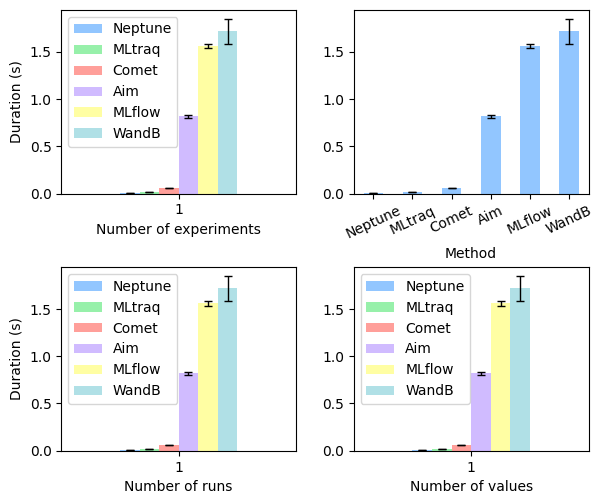


Averaged results by method



,duration,ratio_to_best
method,,
Neptune,0.004513,1.000000
MLtraq,0.014959,3.314676
Comet,0.062743,13.902923
Aim,0.817740,181.200625
MLflow,1.561274,345.958098
WandB,1.717822,380.647034


In [21]:
e = session.create_experiment("exp-1", if_exists="replace")
e.add_runs(
    method=["Aim", "Comet", "WandB", "Neptune", "MLtraq", "MLflow"],
    i=range(10),
    n_experiments=[1],
    n_runs=[1],
    n_values=[1],
)

# Parallelization is disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

# Report results
report_results(e)

The analysis of the test procedures with `pyinstrument` reveals where most of the time is spent for each method:

* WandB and MLflow are the worst performing, with time dominated by threading and events management.
* Aim follows by spending most of the time creating and managing the database.
* Comet is next, with threading management taking most of the time.
* MLtraq spends most of the time writing to SQLite, with no threading.
* Comet is the best performing, with no threading, no SQLite database, simply writing the tracking data to disk.

In summary, the less you do to start up, the faster you are. Threading and communication are expensive, as well as database management.

### Experiment 2: How much time to track 1K and 10K values?

  2%|1         | 1/60 [00:01<01:02,  1.06s/it]

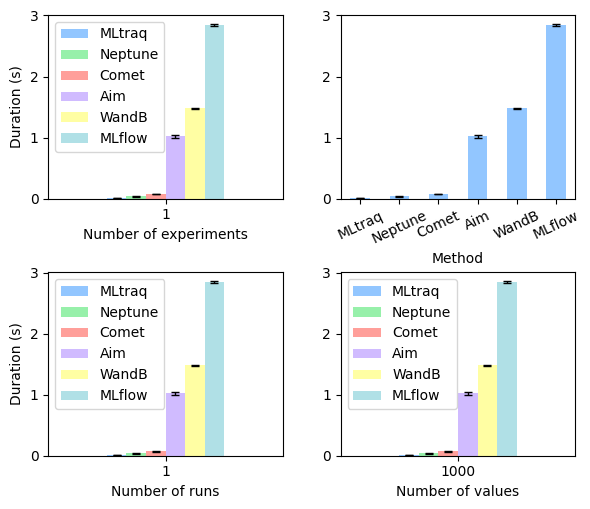


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.014287,1.000000
Neptune,0.036779,2.574230
Comet,0.070776,4.953735
Aim,1.022651,71.577632
WandB,1.482159,103.739594
MLflow,2.843847,199.047175


In [22]:
e = session.create_experiment("exp-2")
e.add_runs(
    method=["Aim", "Comet", "WandB", "Neptune", "MLtraq", "MLflow"],
    i=range(10),
    n_experiments=[1],
    n_runs=[1],
    n_values=[10**3],
)

# Parallelization disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

# Report results
report_results(e)

  2%|1         | 1/60 [00:03<03:27,  3.52s/it]

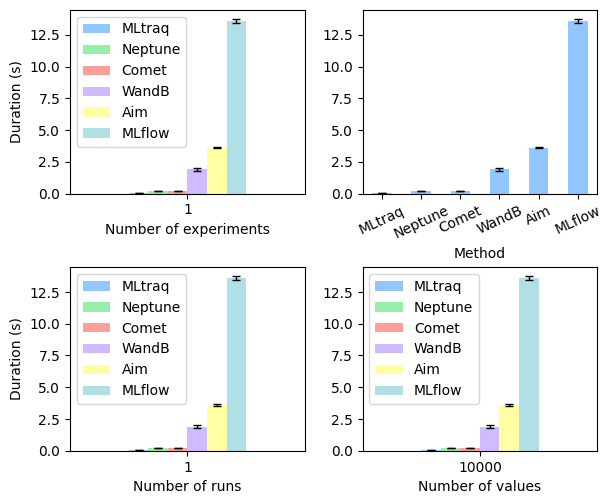


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.021332,1.000000
Neptune,0.223782,10.490353
Comet,0.232167,10.883425
WandB,1.902763,89.196759
Aim,3.605840,169.032739
MLflow,13.603992,637.720995


In [23]:
e = session.create_experiment("exp-2a")
e.add_runs(
    method=["Aim", "Comet", "WandB", "Neptune", "MLtraq", "MLflow"],
    i=range(10),
    n_experiments=[1],
    n_runs=[1],
    n_values=[10**4],
)

# Parallelization disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

# Report results
report_results(e)

* Performance changes dramatically, with WandB, MLflow and Aim being the worst performing, either due to thread communication (WandB, Aim) or database management (MLflow).
* Comet is next, followed by Neptune and MLtraq.

The advantage of MLtraq is in how the data is tracked and stored. Being very close to simply adding an element to an array and serializing it to an SQLite column value with the speedy DATAPAK serialization strategy, it is hard to beat.

### Experiment 3: How much time to track 10 runs?

  2%|1         | 1/60 [00:04<04:30,  4.58s/it]

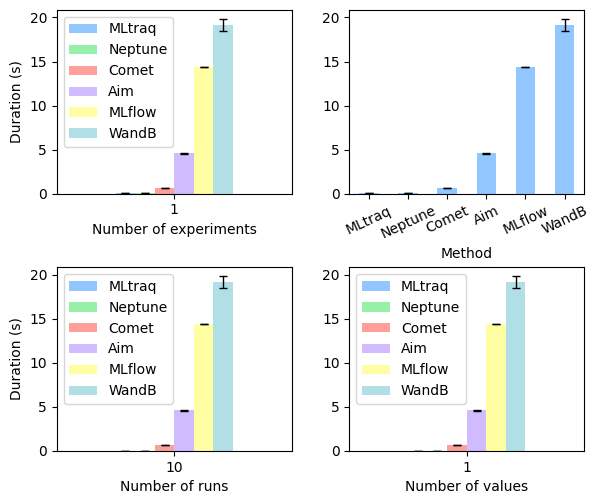


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.015329,1.000000
Neptune,0.021818,1.423301
Comet,0.659452,43.020458
Aim,4.568269,298.018671
MLflow,14.381381,938.193538
WandB,19.183895,1251.493568


In [24]:
e = session.create_experiment("exp-3")
e.add_runs(
    method=["Aim", "Comet", "WandB", "Neptune", "MLtraq", "MLflow"],
    i=range(10),
    n_experiments=[1],
    n_runs=[10],
    n_values=[1],
)

# Parallelization is disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

# Report results
report_results(e)

The results are very similar to Experiment 1, with MLtraq now performing at the top.

* Neptune and Comet use the filesystem as a database, and MLtraq uses SQLite. As the number of files written by Neptune/Comet increases, it becomes more expensive than writing efficiently to a single database file. Writing to a single SQLite file can be 35% faster than writing to many filesystem files. See https://www.sqlite.org/fasterthanfs.html for more details.

* Comet creates a ZIP of the files to be uploaded to their cloud, which results in an additional time penalty.



### Experiment 4: How much time to track 100 runs?

  3%|3         | 1/30 [00:00<00:00, 32.13it/s]

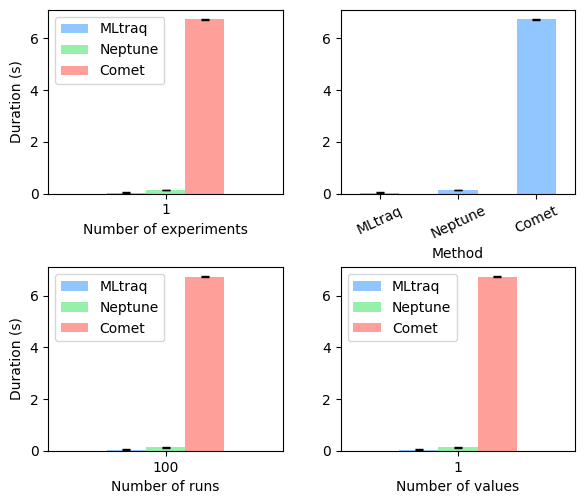


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.035214,1.000000
Neptune,0.126804,3.600972
Comet,6.737881,191.342068


In [25]:
e = session.create_experiment("exp-4")
e.add_runs(
    method=["Comet", "Neptune", "MLtraq"],
    i=range(10),
    n_experiments=[1],
    n_runs=[100],
    n_values=[1],
)

# Parallelization is disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

# Report results
report_results(e)

The results are very similar to Experiment 4. Creating a ZIP of the logs is very expensive for Comet. The other methods have been excluded as they are orders of magnitude slower.

### Experiment 5: How much time to track 1K runs and 1K values each?

  1%|1         | 1/80 [00:23<31:32, 23.96s/it]

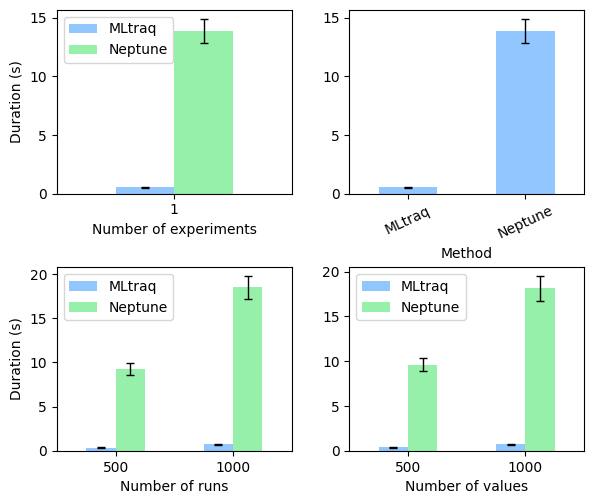


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.543009,1.000000
Neptune,13.889009,25.577845


In [26]:
e = session.create_experiment("exp-5")
e.add_runs(
    method=["Neptune", "MLtraq"],
    i=range(10),
    n_experiments=[1],
    n_runs=[500, 1000],
    n_values=[500, 1000],
)

# Parallelization is disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

# Report results
report_results(e)

* As we increase the number of tracked values or runs, MLtraq becomes more and more competitive. With no threading and no filesystem bottleneck, it is the fastest method for realistic workloads.
* With up to 1K runs and values, MLtraq is 25x faster than Neptune on average.
The other methods, WandB, Aim, Comet and MLflow, are orders of magnitude slower.

### Aggregates

In [27]:
dfs = [session.load(f"exp-{idx}").runs.df() for idx in [1, 2, 3, 4, 5]]
df = pd.concat(dfs).groupby("method").duration.mean().sort_values().to_frame()
df["ratio_to_best"] = df["duration"] / df["duration"].iloc[0]
df

,duration,ratio_to_best
method,,
MLtraq,0.281478,1.000000
Comet,1.882713,6.688662
Aim,2.136220,7.589289
MLflow,6.262167,22.247428
Neptune,6.968244,24.755885
WandB,7.461292,26.507524


### Save plots to SVG files

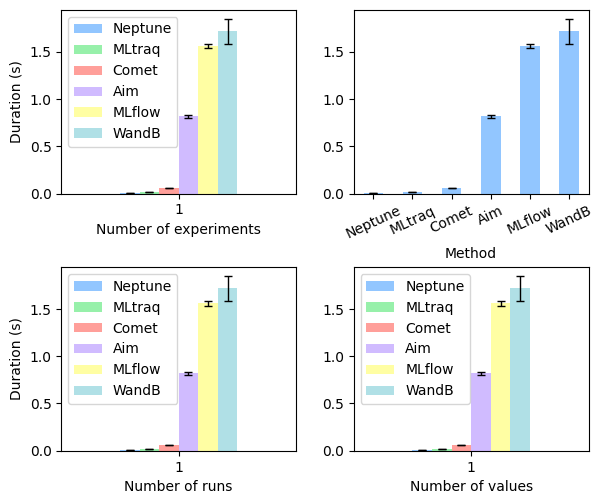


Averaged results by method



,duration,ratio_to_best
method,,
Neptune,0.004513,1.000000
MLtraq,0.014959,3.314676
Comet,0.062743,13.902923
Aim,0.817740,181.200625
MLflow,1.561274,345.958098
WandB,1.717822,380.647034


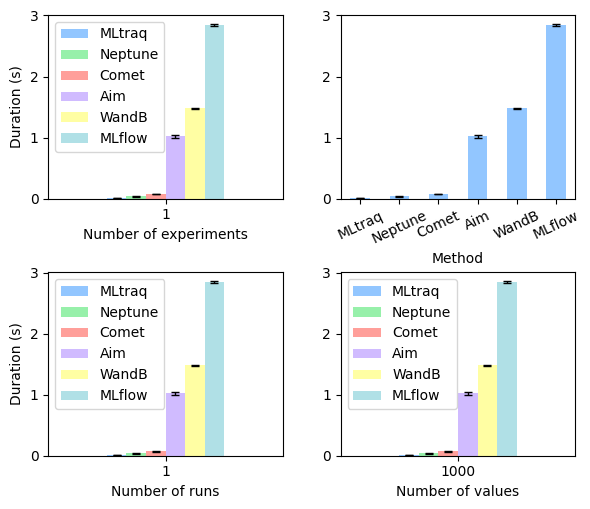


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.014287,1.000000
Neptune,0.036779,2.574230
Comet,0.070776,4.953735
Aim,1.022651,71.577632
WandB,1.482159,103.739594
MLflow,2.843847,199.047175


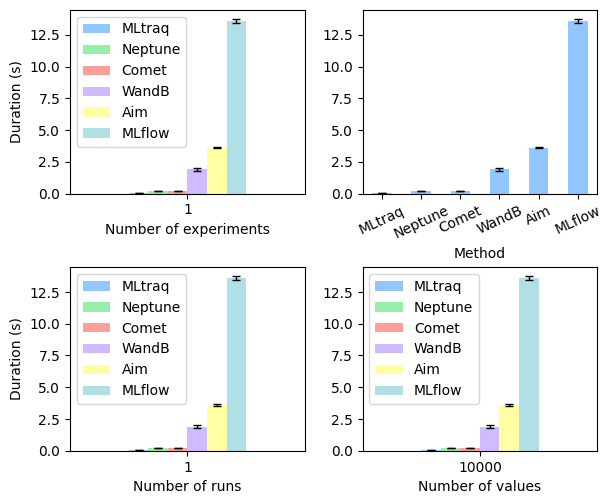


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.021332,1.000000
Neptune,0.223782,10.490353
Comet,0.232167,10.883425
WandB,1.902763,89.196759
Aim,3.605840,169.032739
MLflow,13.603992,637.720995


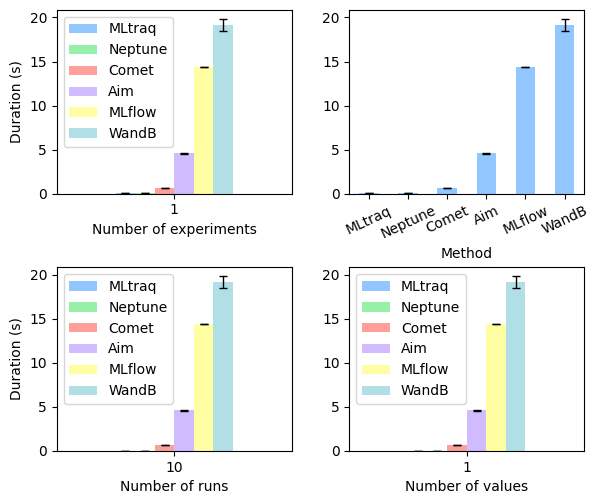


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.015329,1.000000
Neptune,0.021818,1.423301
Comet,0.659452,43.020458
Aim,4.568269,298.018671
MLflow,14.381381,938.193538
WandB,19.183895,1251.493568


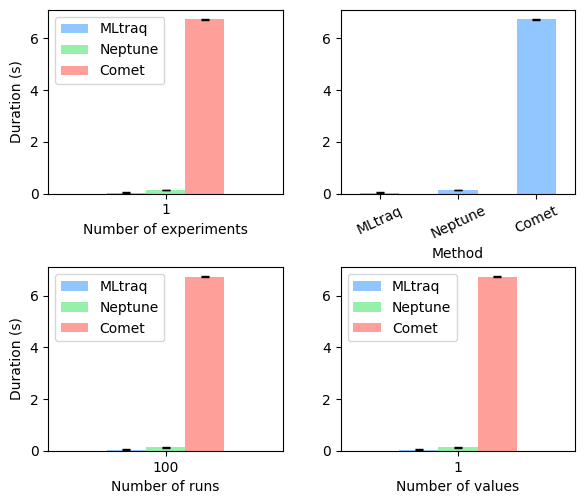


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.035214,1.000000
Neptune,0.126804,3.600972
Comet,6.737881,191.342068


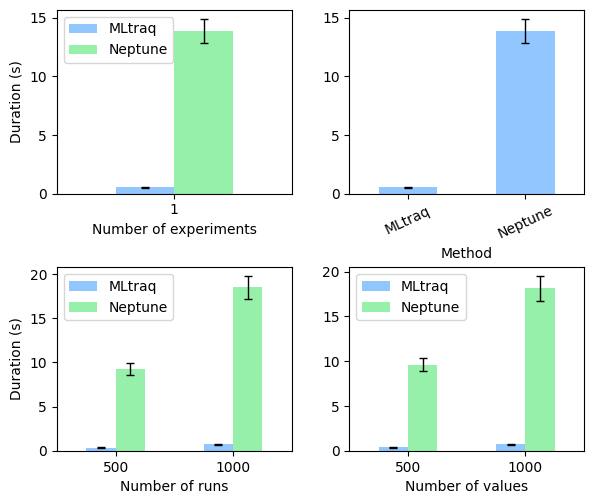


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.543009,1.000000
Neptune,13.889009,25.577845


In [8]:
# Create an MLtraq session to reload the benchmarks
session = mltraq.create_session("sqlite:///local/benchmarks.db")

# Save plots to SVG files
report_results(
    session.load("exp-1"),
    save_svg_to="../mkdocs/assets/img/benchmarks/exp-1.svg",
)
report_results(
    session.load("exp-2"),
    save_svg_to="../mkdocs/assets/img/benchmarks/exp-2.svg",
)
report_results(
    session.load("exp-2a"),
    save_svg_to="../mkdocs/assets/img/benchmarks/exp-2a.svg",
)
report_results(
    session.load("exp-3"),
    save_svg_to="../mkdocs/assets/img/benchmarks/exp-3.svg",
)
report_results(
    session.load("exp-4"),
    save_svg_to="../mkdocs/assets/img/benchmarks/exp-4.svg",
)
report_results(
    session.load("exp-5"),
    save_svg_to="../mkdocs/assets/img/benchmarks/exp-5.svg",
)

## Conclusion

In the experiments, MLtraq is, on average, 7-30x faster than the other methods. The benefits of MLtraq against the most popular choices on workloads with hundreds of thousands of runs and tracked values are even more accentuated and closer to 100x. If speed is among your priorities, you should consider MLtraq to run your experiments. The primary disadvantage of MLtraq is its lack of streaming of the tracking data and the missing web dashboard.
